In [2]:
import kwant
import numpy as np
from cmath import exp
from math import pi, sqrt, tanh
# For plotting
# %run matplotlib_setup.ipy
from matplotlib import pyplot
from ipywidgets import interact
import time
import sys

In [169]:
import tinyarray
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator

t=1.0
t_sc=1.0

# Define the graphene lattice
sin_30, cos_30 = (1 / 2, sqrt(3) / 2)
# graphene = kwant.lattice.general([(1, 0), (sin_30, cos_30)],
#                                  [(0, 0), (0, 1 / sqrt(3))])
graphene = kwant.lattice.general([(0, 1), (cos_30,sin_30)],
                                 [(0.35, 0), (1 / sqrt(3)+0.35,0)])
a, b = graphene.sublattices


tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])
tau_z = tinyarray.array([[1, 0], [0, -1]])

def make_system(Delta=0.2, salt=13, U0=0.0, gn=0.0, gs=0.0, lam=0.0,
                W=200, L=200, Wsc=80, Lsc=20, t_j=0.1, mu=0.6, mu_sc=2,mu_lead=0.6, phi=0):

    
    
    def qh_slab(pos):
        (x, y) = pos 
        if (0 <= x < L) and (0 <= y < W):
            if (int(L/2-Lsc/2)<=x<int(L/2+Lsc/2) ):
                return y>=Wsc
            else:
                return True
        else:
            return False

    def sc_slab(pos):
        (x, y) = pos 
        return ((int(L/2-Lsc/2)-1)<x<int(L/2+Lsc/2) and -Wsc<y<0)

        
    def hopping_ab(site_i, site_j, phi):
        xi, yi = site_i.pos
        xj, yj = site_j.pos
        # modulated hopping in y direction # does not work with vortex
#         H1=tinyarray.array([[-t*exp(1j * pi* phi * (xi + xj) * (yi - yj)),0],\
#                             [0,t*exp(-1j * pi* phi * (xi + xj) * (yi - yj))]])
#         # modulated hopping in x direction
        H1s=tinyarray.array([[-t*exp(-1j * pi* phi * (xi - xj) * (yi + yj)),0],\
                            [0,t*exp(1j * pi* phi * (xi - xj) * (yi + yj))]])
        H1=np.kron(H1s,np.eye(2))
        return H1
    
    def onsite(site, mu, gn, U0, salt):
        return  (U0 * (uniform(repr(site), repr(salt)) - 0.5)- mu + 4 * t)* np.kron(tau_z,np.eye(2))-gn* np.kron(tau_z,tau_z)

    def onsite_sc(site, mu_sc, gs, U0, Delta, salt):
        return  (U0 * (uniform(repr(site), repr(salt)) - 0.5)- mu_sc + 4 * t_sc)* np.kron(tau_z,np.eye(2))\
                + Delta * np.kron(tau_y,tau_y)- gs* np.kron(tau_z,tau_z)

    
    lat = kwant.lattice.honeycomb(norbs=1)
    subA, subB = lat.sublattices
    syst = kwant.Builder()
    syst[lat.shape(qh_slab, (L-1,W-1))] = 1
    # specify the hoppings of the graphene lattice in the
    # format expected by builder.HoppingKind
#     hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
#     syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -1
    syst[lat.neighbors()] = -1

    a0=3/(4*sqrt(3))
    Wsq=int(Wsc/a0)
    primitive_vectors = [(a0, 0), (0, a0)]
    lat_lead = kwant.lattice.Monatomic(primitive_vectors, offset=(a0/4, a0/6),norbs=1)
#     lat_lead = kwant.lattice.square(norbs=1,a=a0)
    i_L=int((L/2-Lsc/2)/a0)
    i_R=int((L/2+Lsc/2)/a0)
    syst[(lat_lead(i, j) for i in range(i_L,i_R) for j in range(Wsq))] = 4
    syst[lat_lead.neighbors()] = -1

    # Manually attach sites from graphene to square lattice
    syst[((lat_lead(i_L, 2*i), subA(int(L/2-Lsc/2)-int(i/2)-1, i)) for i in range(int(Wsq/2)))] = -1
    syst[((lat_lead(i_L, 2*i+1), subB(int(L/2-Lsc/2)-int(i/2)-1, i)) for i in range(int(Wsq/2)))] = -1

    syst[((lat_lead(i_R-1, 2*i), subA(int(L/2+Lsc/2)-int(i/2), i)) for i in range(int(Wsq/2)))] = -1
    syst[((lat_lead(i_R-1, 2*i+1), subB(int(L/2+Lsc/2)-int(i/2), i)) for i in range(int(Wsq/2)))] = -1

#     syst[((lat_lead(2*i+i_L, 2*Wsc-1), subB(i+2, Wsc)) for i in range(Lsc))] = -1
#     syst[((lat_lead(2*i+i_L+1, 2*Wsc-1), subA(i+2, Wsc+1)) for i in range(Lsc))] = -1



#     syst[(lat_lead(i_L, 4),subA(int(L/2-Lsc/2)-2, 2))]=-1
    
#     syst[(lat(x, y) for x in range(L) for y in range(W))] = onsite
#     syst[(lat(x, y) for x in range(int(L/2-Lsc/2),int(L/2+Lsc/2) ) for y in range(Wsc))] = onsite_sc
#     syst[lat.neighbors()] = hopping
    
#     a0=3/(4*sqrt(3))
#     lat = kwant.lattice.square(norbs=1,a=a0)
#     sym_bottom = kwant.TranslationalSymmetry((0, -1))
# #     bottom_lead = kwant.Builder(sym_bottom, particle_hole=np.kron(tau_x,np.eye(2)))
#     bottom_lead = kwant.Builder(sym_bottom)
# #     bottom_lead[(lat(x, 0) for x in range(int(L/2-Lsc/2),int(L/2+Lsc/2))) ] = onsite_sc
#     bottom_lead[(lat(x, 0) for x in range(4*L-2))] = 1
#     bottom_lead[lat.neighbors()] = 1 # hopping_sc
# #     bottom_lead = kwant.Builder(sym_bottom, conservation_law=-tau_z, particle_hole=tau_y)
# #     bottom_lead[(lat(x, 0) for x in range(int(L/2-L/4),int(L/2+L/4))) ] = onsite_lead
# #     bottom_lead[lat.neighbors()] = hopping_lead
# #     syst.attach_lead(bottom_lead)
    
    return syst

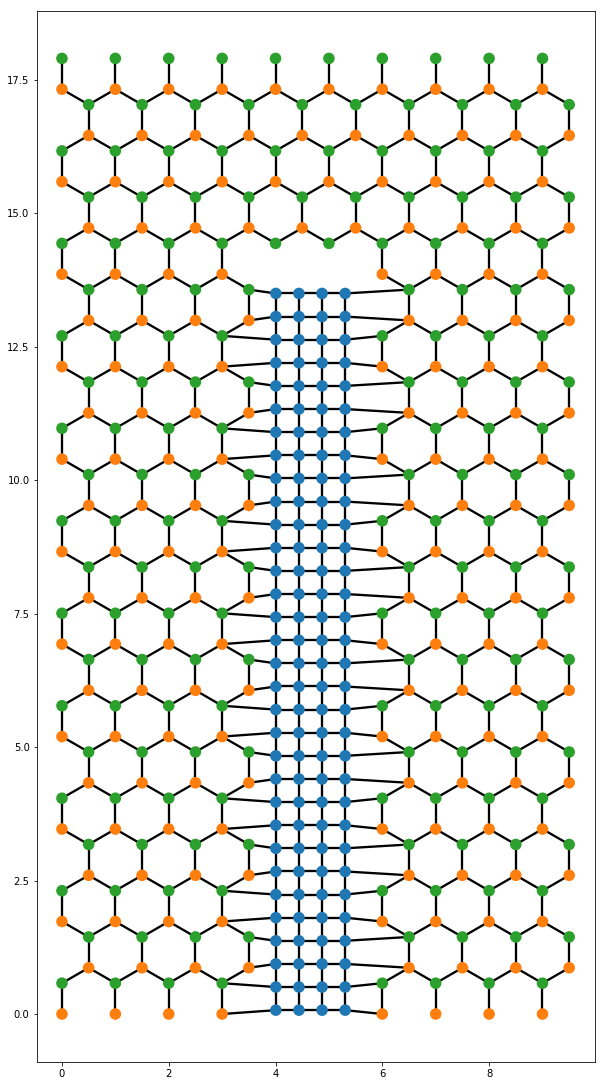

In [184]:
# Wsc must be multiples of eight
Wsc=14
W=Wsc+4
Lsc=2
L=Lsc+8
syst = make_system(W=W, L=L, Wsc=Wsc, Lsc=Lsc)
# Check that the system looks as intended.
kwant.plot(syst, colorbar=False,fig_size=(10,40))
# kwant.plot(syst)
# Finalize the system.
syst = syst.finalized()

(4, 29120)


/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: The plotted data contains 1.51% of values overflowing upper limit 0.616988 


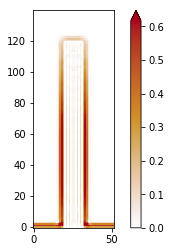

/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: The plotted data contains 0.49% of values overflowing upper limit 0.0701253 


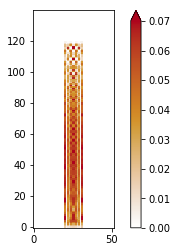

/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: The plotted data contains 1.54% of values overflowing upper limit 0.00983832 


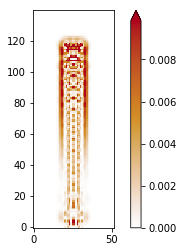

/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: The plotted data contains 1.57% of values overflowing upper limit 0.0106796 


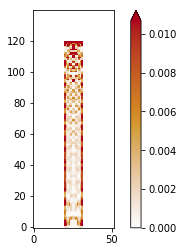

In [92]:
mu_lead=0.6
mu=0.6
mu_sc=1.5
phi=0.05
U0=0.0 # disorder strength
salt=13
Delta=0.06
t_j=0.6
gs=0.
gn=20
lam=0.4

energy=0.*Delta
params=dict(t_j=t_j, gn=gn, lam=lam, gs=gs, Delta=Delta, mu_lead=mu_lead ,mu=mu-gn,mu_sc=mu_sc,phi=phi,U0=U0,salt=salt)
wfs = kwant.wave_function(syst, energy=energy, params=params)
scattering_wf = wfs(0)  # all scattering wave functions from lead 0
# kwant.plotter.map(syst, np.sum(abs(scattering_wf[:,::2])**2, axis=0)-np.sum(abs(scattering_wf[:,1::2])**2, axis=0));
# kwant.plotter.map(syst, np.sum(abs(scattering_wf[:,1::2])**2, axis=0));
print(scattering_wf.shape)
ind=0
# fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(1, 4, sharey=True, figsize=(12, 4))
# kwant.plotter.map(syst, abs(scattering_wf[ind,::4])**2-abs(scattering_wf[ind,3::4])**2,ax=ax1);
# kwant.plotter.map(syst, abs(scattering_wf[ind,1::4])**2-abs(scattering_wf[ind,2::4])**2,ax=ax2);
kwant.plotter.map(syst, abs(scattering_wf[ind,::4])**2)#,vmax=0.7);#,ax=ax1);
kwant.plotter.map(syst, abs(scattering_wf[ind,1::4])**2);#,ax=ax2);
kwant.plotter.map(syst, abs(scattering_wf[ind,2::4])**2)#,vmax=0.1);#,ax=ax3);
kwant.plotter.map(syst, abs(scattering_wf[ind,3::4])**2);#,ax=ax4);

/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: The plotted data contains 1.80% of values overflowing upper limit 0.00517432 
  


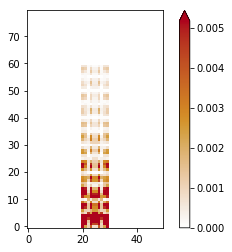

/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: The plotted data contains 1.30% of values overflowing upper limit 4.21151e-26 
  import sys


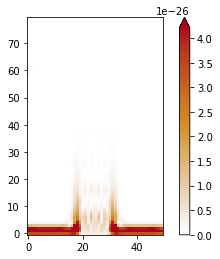

/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: The plotted data contains 1.73% of values overflowing upper limit 6.33769e-28 
  


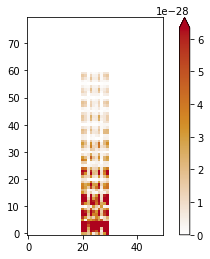

/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: The plotted data contains 1.20% of values overflowing upper limit 0.368867 
  if __name__ == '__main__':


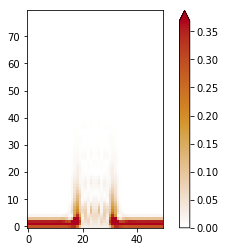

In [158]:
ind=3
# print(scattering_wf.shape)
# fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(1, 4, sharey=True, figsize=(12, 4))
# kwant.plotter.map(syst, abs(scattering_wf[ind,::4])**2-abs(scattering_wf[ind,3::4])**2,ax=ax1);
# kwant.plotter.map(syst, abs(scattering_wf[ind,1::4])**2-abs(scattering_wf[ind,2::4])**2,ax=ax2);
kwant.plotter.map(syst, abs(scattering_wf[ind,::4])**2);#,ax=ax1);
kwant.plotter.map(syst, abs(scattering_wf[ind,1::4])**2);#,ax=ax2);
kwant.plotter.map(syst, abs(scattering_wf[ind,2::4])**2);#,ax=ax3);
kwant.plotter.map(syst, abs(scattering_wf[ind,3::4])**2);#,ax=ax4);

In [ ]:
mu=0.1
mu_sc=1.5
phi=0.01
U0=0.5 # disorder strength
salt=13
Delta=0.02
t_j=0.5

    pyplot.figure()
    pyplot.plot(np.array(energies)/Delta, np.array(Pe)-np.array(Ph))
#     pyplot.plot(energies, Ph)
#     pyplot.plot(energies, data)
    pyplot.xlabel("energy [Delta]")
    pyplot.ylabel(r"$P_e - P_h$")
    pyplot.show()
    
E_list=np.arange(-20, 21)*Delta/10
t_timer=time.time()
# Compute and plot the conductance
plot_conductance(syst, energies=[E for E in E_list])
elapsed = time.time() - t_timer
print("Finished, elapsed time = %.0f " % (elapsed)+ "sec")

In [ ]:
mu_sc=1.5
phi=0.01
U0=0.5 # disorder strength
salt=13
Delta=0.02
t_j=0.5

def plot_conductance(syst, mu_sw):
    # Compute conductance
    Nrep=10
    vec=np.zeros((len(mu_sw),Nrep))
#     print(np.shape(vec))
    for salt in range(Nrep):
        print(salt, end='\r')
        for i_mu in range(len(mu_sw)):
            mu=mu_sw[i_mu]
            smatrix = kwant.smatrix(syst,energy=0,params=dict(t_j=t_j,Delta=Delta,mu=mu,mu_sc=mu_sc,phi=phi,U0=U0,salt=salt))    
            # Conductance is N - R_ee + R_he
            vec[i_mu,salt]=(smatrix.transmission((1, 0), (0, 0)) -
                        smatrix.transmission((1, 1), (0, 0)))
#         vec=vec+data
#         print([np.shape(vec),np.shape(data)])
    
    cond_avg=np.mean(vec,axis=1)
    pyplot.figure()
    pyplot.plot(np.reshape(mu_sw,[len(mu_sw),1]), vec,'b')
    pyplot.plot(np.reshape(mu_sw,[len(mu_sw),1]), cond_avg,'r')
    pyplot.xlabel(r"$\mu [t]$")
    pyplot.ylabel(r"$P_e - P_h$")
    pyplot.show()
    
# Compute and plot the conductance
plot_conductance(syst, mu_sw=[0.01 * i for i in range(5, 20)])